In [46]:
#varational nn libraries
!pip install torchbnn
!pip install torch
import numpy as np
from sklearn import datasets
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
import matplotlib.pyplot as plt
import time

In [2]:
#MCMC libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
!pip install ipywidgets
from ipywidgets import interact, fixed, widgets
!pip install tqdm
from tqdm import tqdm
from types import MethodType

  Using cached ipywidgets-8.0.6-py3-none-any.whl (138 kB)
  Using cached jupyterlab_widgets-3.0.7-py3-none-any.whl (198 kB)
  Using cached widgetsnbextension-4.0.7-py3-none-any.whl (2.1 MB)
  Using cached tqdm-4.65.0-py3-none-any.whl (77 kB)


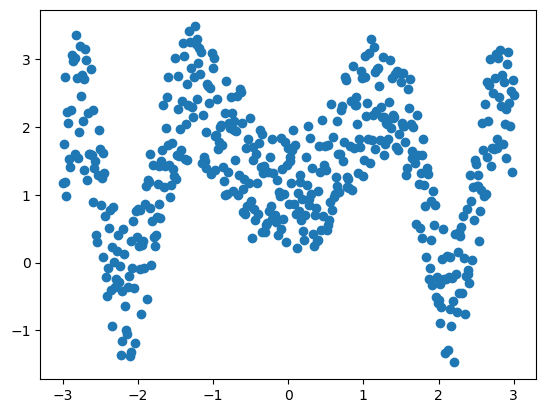

In [3]:
x = torch.linspace(-3, 3, 500)
y = 1.5*torch.sin(x**2) + 2*torch.rand(x.size())
x = torch.unsqueeze(x, dim=1)
y = torch.unsqueeze(y, dim=1)

plt.scatter(x.data.numpy(), y.data.numpy())
plt.show()

In [4]:
def clean_target(x):
    return 1.5*torch.sin(x**2) + 1
def target(x):
    return 1.5*torch.sin(x**2) + 2*torch.rand(x.size())

In [5]:
#feed-forward
model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=1, out_features=1000),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=1000, out_features=500),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=500, out_features=1),
)

In [6]:
#MSE loss and KL Divergence
mse_loss = nn.MSELoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.01

optimizer = optim.Adam(model.parameters(), lr=0.01)

In [7]:
for step in range(3000):
    pre = model(x)
    mse = mse_loss(pre, y)
    kl = kl_loss(model)
    cost = mse + kl_weight*kl
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
print('- MSE : %2.2f, KL : %2.2f' % (mse.item(), kl.item()))

- MSE : 1.02, KL : 0.28


In [8]:
x_test = torch.linspace(-2, 2, 300)
y_test = target(x_test)

x_test = torch.unsqueeze(x_test, dim=1)
y_test = torch.unsqueeze(y_test, dim=1)

In [9]:
models_result = np.array([model(x_test).data.numpy() for k in range(10000)])
models_result = models_result[:,:,0]    
models_result = models_result.T
mean_values = np.array([models_result[i].mean() for i in range(len(models_result))])
std_values = np.array([models_result[i].std() for i in range(len(models_result))])

Text(0, 0.5, 'y')

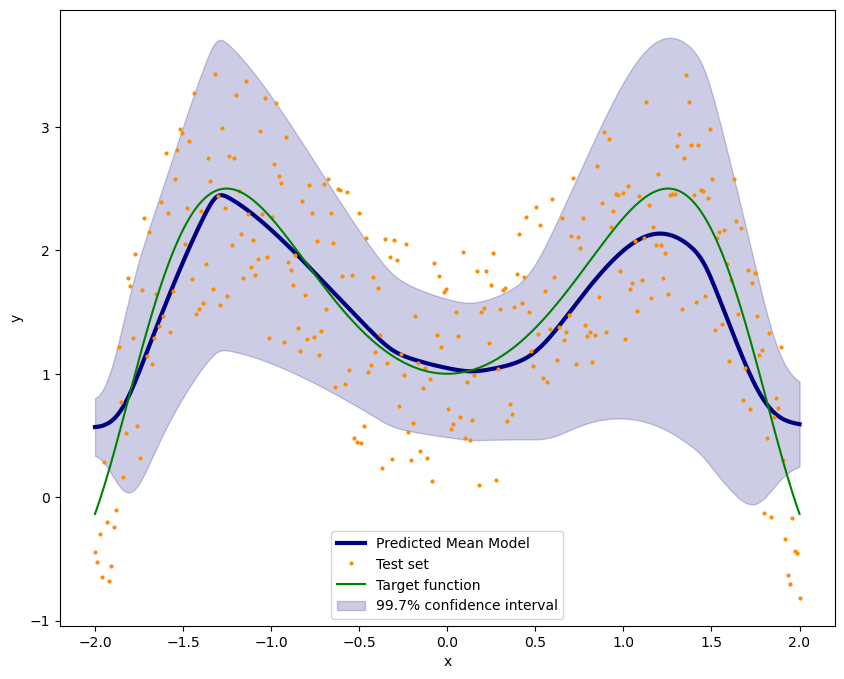

In [10]:
plt.figure(figsize=(10,8))
plt.plot(x_test.data.numpy(),mean_values,color='navy',lw=3,label='Predicted Mean Model')
plt.fill_between(x_test.data.numpy().T[0],mean_values-3.0*std_values,mean_values+3.0*std_values,alpha=0.2,color='navy',label='99.7% confidence interval')
#plt.plot(x_test.data.numpy(),mean_values,color='darkorange')
plt.plot(x_test.data.numpy(),y_test.data.numpy(),'.',color='darkorange',markersize=4,label='Test set')
plt.plot(x_test.data.numpy(),clean_target(x_test).data.numpy(),color='green',markersize=4,label='Target function')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')

In [11]:
concrete = df = pd.read_csv(r"Data/Concrete_Data_Yeh.csv")
concrete

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77


In [42]:
np.random.seed(0)
train_index = np.random.choice([i for i in range(1030)], size = 800, replace = False)
train_df = concrete.iloc[train_index,:]
test_df = concrete.loc[~ concrete.index.isin(train_index)]

In [43]:
#preprocessing
std_scaler = StandardScaler()

train_x = std_scaler.fit_transform(train_df.iloc[:,:7].to_numpy())
train_y = train_df.iloc[:,8].to_numpy()

test_x = std_scaler.fit_transform(test_df.iloc[:,:7].to_numpy())
test_y = test_df.iloc[:,8].to_numpy()

x, y = torch.from_numpy(train_x).float(), torch.from_numpy(train_y).float()

x_test, y_test = torch.from_numpy(test_x).float(), torch.from_numpy(test_y).float()
print(x.shape, y.shape)

torch.Size([800, 7]) torch.Size([800])


In [44]:
#feed-forward
model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=2, in_features=7, out_features=1000),
    nn.Sigmoid(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=2, in_features=1000, out_features=500),
    nn.Sigmoid(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=2, in_features=500, out_features=1),
)

In [45]:
#MSE loss and KL Divergence
mse_loss = nn.MSELoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.01

optimizer = optim.Adam(model.parameters(), lr=0.01)

In [47]:
start_time = time.time()
for step in range(5000):
    pre = model(x)
    mse = mse_loss(pre, y.unsqueeze(1))
    kl = kl_loss(model)
    cost = mse + kl_weight*kl
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
print('- MSE : %2.2f, KL : %2.2f' % (mse.item(), kl.item()))
print("--- %s seconds ---" % (time.time() - start_time))

- MSE : 158.04, KL : 0.10
--- 347.66208052635193 seconds ---


In [48]:
models_result = np.array([model(x_test).data.numpy() for k in range(10000)])
models_result = models_result[:,:,0]    
models_result = models_result.T
mean_values = np.array([models_result[i].mean() for i in range(len(models_result))])
std_values = np.array([models_result[i].std() for i in range(len(models_result))])

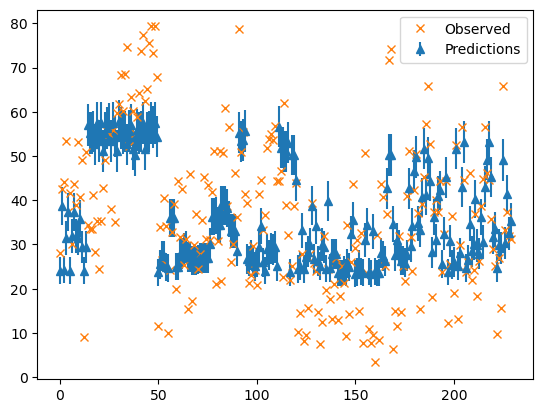

In [49]:
plt.errorbar([i for i in range(230)], mean_values, std_values, linestyle='None', marker='^', label = "Predictions")
plt.plot([i for i in range(230)], test_y, linestyle='None', marker='x', label = "Observed")
plt.legend()

In [19]:
iris = datasets.load_iris()

X = iris.data
Y = iris.target 

x, y = torch.from_numpy(X).float(), torch.from_numpy(Y).long()
print(x.shape, y.shape)


torch.Size([150, 4]) torch.Size([150])


In [20]:
model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=4, out_features=100),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=100, out_features=3),
)

ce_loss = nn.CrossEntropyLoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.01

optimizer = optim.Adam(model.parameters(), lr=0.01)

In [21]:
kl_weight = 0.1

for step in range(3000):
    pre = model(x)
    ce = ce_loss(pre, y)
    kl = kl_loss(model)
    cost = ce + kl_weight*kl
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
_, predicted = torch.max(pre.data, 1)
total = y.size(0)
correct = (predicted == y).sum()
print('- Accuracy: %f %%' % (100 * float(correct) / total))
print('- CE : %2.2f, KL : %2.2f' % (ce.item(), kl.item()))

- Accuracy: 96.666667 %
- CE : 0.11, KL : 1.27


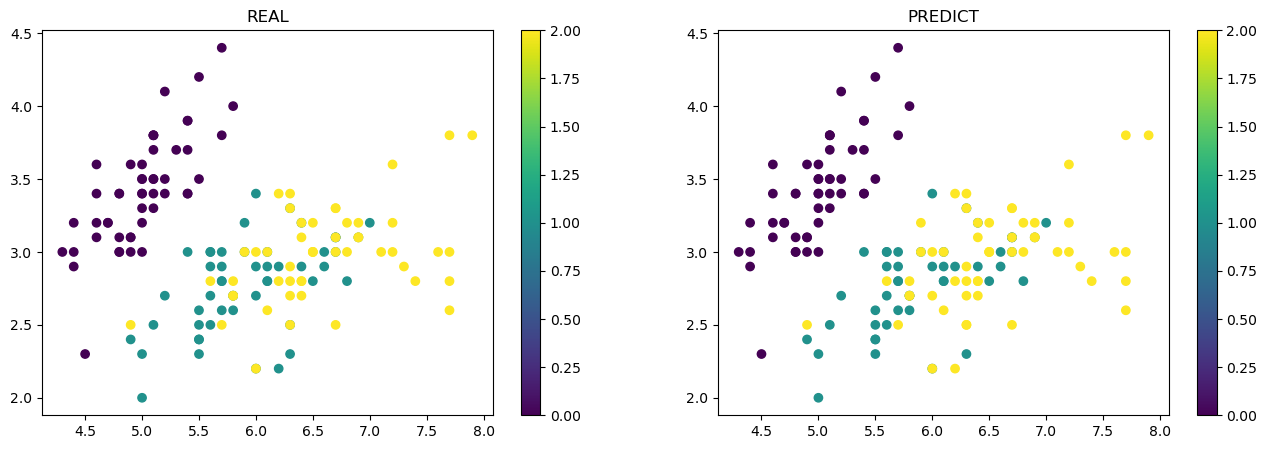

In [22]:


def draw_plot(predicted) :
    fig = plt.figure(figsize = (16, 5))

    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)

    z1_plot = ax1.scatter(X[:, 0], X[:, 1], c = Y)
    z2_plot = ax2.scatter(X[:, 0], X[:, 1], c = predicted)

    plt.colorbar(z1_plot,ax=ax1)
    plt.colorbar(z2_plot,ax=ax2)

    ax1.set_title("REAL")
    ax2.set_title("PREDICT")

    plt.show()

pre = model(x)
_, predicted = torch.max(pre.data, 1)
draw_plot(predicted)

In [23]:
def gen_data(n):
    #' Creates data with n points
    x1 = np.random.normal(0, np.sqrt(1.5), n)
    x2 = np.random.normal(0, np.sqrt(1.5), n)
    X = np.matrix([[x1[i], x2[i]] for i in range(n)])
    mean_y = np.ones(n) * 5
    for i in range(n):
        if x1[i]**2 + x2[i]**2 < 2:
            mean_y[i] = 10
    y = np.random.normal(mean_y, np.sqrt(0.01), n)
    return(X, y)

In [24]:
x_dat, y_dat = gen_data(1000)
x, y = torch.from_numpy(x_dat).float(), torch.from_numpy(y_dat).float()
x = torch.unsqueeze(x, dim=1)
y = torch.unsqueeze(y, dim=1)

In [25]:
model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=5, in_features=2, out_features=1000),
    nn.Tanh(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=5, in_features=1000, out_features=500),
    nn.Tanh(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=5, in_features=500, out_features=200),
    nn.Tanh(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=5, in_features=200, out_features=200),
    nn.Tanh(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=5, in_features=200, out_features=100),
    nn.Tanh(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=5, in_features=100, out_features=1),
)

#MSE loss and KL Divergence
mse_loss = nn.MSELoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.01

optimizer = optim.Adam(model.parameters(), lr=0.01)

In [26]:
kl_weight = 0.1
for step in range(1000):
    pre = model(x)
    mse = mse_loss(pre, y.unsqueeze(1))
    kl = kl_loss(model)
    cost = mse + kl_weight*kl
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
print('- MSE : %2.2f, KL : %2.2f' % (mse.item(), kl.item()))

- MSE : 103.85, KL : 0.02


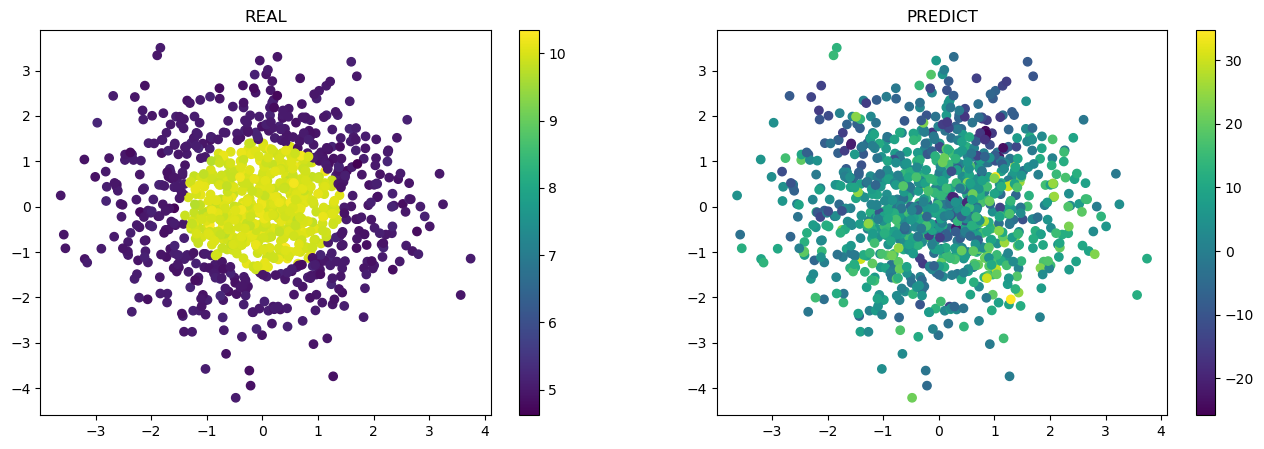

In [27]:
pre = model(x)
fig = plt.figure(figsize = (16, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

z1_plot = ax1.scatter([x_dat[:, 0]], [x_dat[:, 1]], c = y)
z2_plot = ax2.scatter([x_dat[:, 0]], [x_dat[:, 1]], c = pre.detach().numpy())

plt.colorbar(z1_plot,ax=ax1)
plt.colorbar(z2_plot,ax=ax2)

ax1.set_title("REAL")
ax2.set_title("PREDICT")

plt.show()



Sampling: MCMC 

In [28]:
# NN prediction
def forward_pass(self, X):
    '''
    Take an input X and return the output of the network
    Input:
        - X: (N x num_features) array of input data
    Output:
        - self.l2_output: (N) array of output data f(x) which can be 
        compared to observations (Y)
    '''
    # Hidden layer
    l1_z = np.dot(X, self.l1_weights) + self.l1_biases
    self.l1_output = self.sigmoid(l1_z) # activation function g(.)
    # Output layer
    l2_z = np.dot(self.l1_output, self.l2_weights) + self.l2_biases
    self.l2_output = self.sigmoid(l2_z)
    return self.l2_output

def backward_pass(self, X, Y):
    '''
    Compute the gradients using a backward pass and undertake Langevin-gradient 
    updating of parameters
    Input:
        - X: (N x num_features) array of input data
        - Y: (N) array of target data
    '''
    # dE/dtheta
    l2_delta = (Y - self.l2_output) * (self.l2_output * (1 - self.l2_output))
    l2_weights_delta = np.outer(
        self.l1_output,
        l2_delta
    )
    # backprop of l2_delta and same as above
    l1_delta = np.dot(int(l2_delta),self.l2_weights.T) * (self.l1_output.T * (1 - self.l1_output))        
    l1_weights_delta = np.outer(
        X,
        l1_delta
    )

    # update for output layer
    self.l2_weights += self.lrate * l2_weights_delta
    self.l2_biases[0] += self.lrate * l2_delta[0]
    # update for hidden layer
    self.l1_weights += self.lrate * l1_weights_delta
    for i in range(self.input_num):
        self.l1_biases[i] += self.lrate * l1_delta[0,i]

In [29]:
class NeuralNetwork:
    '''
    Neural Network model with a single hidden layer and a single output (y)
    '''
    def __init__(self, layer_sizes,learning_rate=0.01):
        '''
        Initialize the model
        Input:
            - layer_sizes (input, hidden, output): array specifying the number of 
            nodes in each layer
            - learning_rate: learning rate for the gradient update
        '''
        # Initial values of model parameters
        self.input_num = layer_sizes[0]
        self.hidden_num = layer_sizes[1]
        self.output_num = layer_sizes[2]

        # total number of parameters from weights and biases
        self.n_params = (self.input_num * self.hidden_num) + (self.hidden_num * self.output_num) +\
            self.hidden_num + self.output_num
        # learning params
        self.lrate = learning_rate

        # Initialize network structure
        self.initialise_network()

        # functions defined above - this is poor practice, but done for readability 
        # and clarity
        self.forward_pass = MethodType(forward_pass, self)
        self.backward_pass = MethodType(backward_pass, self)

    def initialise_network(self):
        '''
        Initialize network structure - weights and biases for the hidden layer
        and output layer
        '''
        # hidden layer
        self.l1_weights = np.random.normal(
            loc=0, scale=1/np.sqrt(self.input_num),
            size=(self.input_num, self.hidden_num))
        self.l1_biases = np.random.normal(
            loc=0, scale=1/np.sqrt(self.hidden_num), 
            size=(self.hidden_num,))
        # placeholder for storing the hidden layer values
        self.l1_output = np.zeros((1, self.hidden_num))

        # output layer
        self.l2_weights = np.random.normal(
            loc=0, scale=1/np.sqrt(self.hidden_num), 
            size=(self.hidden_num, self.output_num))
        self.l2_biases = np.random.normal(
            loc=0, scale=1/np.sqrt(self.hidden_num), 
            size=(self.output_num,))
        # placeholder for storing the model outputs
        self.l2_output = np.zeros((1, self.output_num))

    def evaluate_proposal(self, x_data, theta):
        '''
        A helper function to take the input data and proposed parameter sample 
        and return the prediction
        Input:
            data: (N x num_features) array of data
            theta: (w,v,b_h,b_o) vector of parameters with weights and biases
        '''
        self.decode(theta)  # method to decode w into W1, W2, B1, B2.
        size = x_data.shape[0]

        fx = np.zeros(size)
        prob = np.zeros((size,self.output_num))

        for i in range(0, size):  # to see what fx is produced by your current weight update
            fx_tmp = self.forward_pass(x_data[i,])
            # regression
            fx[i] = fx_tmp

        return fx, prob

    def langevin_gradient(self, x_data, y_data, theta, depth):
        '''
        Compute the Langevin gradient based proposal distribution
        Input:
            - x_data: (N x num_features) array of input data
            - y_data: (N) array of target data
            - theta: (w,v,b_h,b_o) vector of proposed parameters.
            - depth: SGD depth
        Output: 
            - theta_updated: Updated parameter proposal

        '''
        self.decode(theta)  # method to decode w into W1, W2, B1, B2.
        size = x_data.shape[0] 
        # Update the parameters based on LG 
        for _ in range(0, depth):
            for ii in range(0, size):
                self.forward_pass(x_data[ii,])
                self.backward_pass(x_data[ii,], y_data[ii])
        theta_updated = self.encode()
        return  theta_updated

    # Helper functions
    def sigmoid(self, x):
        '''
        Implentation of the sigmoid function
        '''
        return 1 / (1 + np.exp(-x))
        
    def encode(self):
        '''
        Encode the model parameters into a vector
        Output:
            - theta: vector of parameters.
        '''
        w1 = self.l1_weights.ravel()
        w2 = self.l2_weights.ravel()
        theta = np.concatenate([w1, w2, self.l1_biases, self.l2_biases])
        return theta
        
    def decode(self, theta):
        '''
        Decode the model parameters from a vector
        Input:
            - theta: vector of parameters.
        '''
        w_layer1size = self.input_num * self.hidden_num
        w_layer2size = self.hidden_num * self.output_num

        w_layer1 = theta[0:w_layer1size]
        self.l1_weights = np.reshape(w_layer1, (self.input_num, self.hidden_num))

        w_layer2 = theta[w_layer1size:w_layer1size + w_layer2size]
        self.l2_weights = np.reshape(w_layer2, (self.hidden_num, self.output_num))
        self.l1_biases = theta[w_layer1size + w_layer2size:w_layer1size + w_layer2size + self.hidden_num]
        self.l2_biases = theta[w_layer1size + w_layer2size + self.hidden_num:w_layer1size + w_layer2size + self.hidden_num + self.output_num]

In [30]:
# Define the likelihood function
def likelihood_function(self, theta, tausq, test=False):
    '''
    Calculate the likelihood of the data given the parameters
    Input:
        theta: (M + 1) vector of parameters. The last element of theta consitutes the bias term (giving M + 1 elements)
        tausq: variance of the error term
    Output:
        log_likelihood: log likelihood of the data given the parameters
        model_prediction: prediction of the model given the parameters
        accuracy: accuracy (RMSE) of the model given the parameters
    '''
    # first make a prediction with parameters theta
    if test:
        x_data = self.x_test
        y_data = self.y_test
    else:
        x_data = self.x_data
        y_data = self.y_data
    model_prediction, _ = self.model.evaluate_proposal(x_data, theta)
    model_simulation = model_prediction + np.random.normal(0,tausq,size=model_prediction.shape) 
    accuracy = self.rmse(model_prediction, y_data) #RMSE error metric 
    # now calculate the log likelihood
    log_likelihood = np.sum(-0.5 * np.log(2 * np.pi * tausq) - 0.5 * np.square(y_data - model_prediction) / tausq)
    return [log_likelihood, model_prediction, model_simulation, accuracy] 

# Define the prior
def prior_likelihood(self, sigma_squared, nu_1, nu_2, theta, tausq): 
    '''
    Calculate the prior likelihood of the parameters
    Input:
        sigma_squared: variance of normal prior for theta
        nu_1: parameter nu_1 of the inverse gamma prior for tau^2
        nu_2: parameter nu_2 of the inverse gamma prior for tau^2
        theta: (M + 1) vector of parameters. The last element of theta consitutes the bias term (giving M + 1 elements)
        tausq: variance of the error term
    Output:
        log_prior: log prior likelihood
    '''
    n_params = self.theta_size # number of parameters in model
    part1 = -1 * (n_params / 2) * np.log(sigma_squared)
    part2 = 1 / (2 * sigma_squared) * (sum(np.square(theta)))
    log_prior = part1 - part2 - (1 + nu_1) * np.log(tausq) - (nu_2 / tausq)
    return log_prior

In [31]:
# MCMC sampler
def sampler(self):
    '''
    Run the sampler for a defined Neural Network model
    '''
    # define empty arrays to store the sampled posterior values
    # posterior of all weights and bias over all samples
    pos_theta = np.ones((self.n_samples, self.theta_size)) 
    # posterior defining the variance of the noise in predictions
    pos_tau = np.ones((self.n_samples, 1))
    pos_eta = np.ones((self.n_samples, 1))

    # record output f(x) over all samples
    pred_y = np.zeros((self.n_samples, self.x_data.shape[0]))
    # record simulated values f(x) + error over all samples 
    sim_y = np.zeros((self.n_samples, self.x_data.shape[0]))
    # record the RMSE of each sample
    rmse_data = np.zeros(self.n_samples)
    # now for test
    test_pred_y = np.ones((self.n_samples, self.x_test.shape[0]))
    test_sim_y = np.ones((self.n_samples, self.x_test.shape[0]))
    test_rmse_data = np.zeros(self.n_samples)

    ## Initialisation
    # initialise theta
    theta = np.random.randn(self.theta_size)
    # make initial prediction
    pred_y[0,], _ = self.model.evaluate_proposal(self.x_data, theta)

    # initialise eta
    eta = np.log(np.var(pred_y[0,] - self.y_data))
    tau_proposal = np.exp(eta)

    # Hyperpriors - considered by looking at distribution of  similar trained  models - i.e distribution of weights and bias
    sigma_squared = self.sigma_squared
    nu_1 = self.nu_1
    nu_2 = self.nu_2

    # calculate the prior likelihood
    prior_likelihood = self.prior_likelihood(sigma_squared, nu_1, nu_2, theta, tau_proposal)
    # calculate the likelihood considering observations
    [likelihood, pred_y[0,], sim_y[0,], rmse_data[0]] = self.likelihood_function(theta, tau_proposal)

    n_accept = 0  
    n_langevin = 0
    # Run the MCMC sample for n_samples
    for ii in tqdm(np.arange(1,self.n_samples)):
        # Sample new values for theta and tau
        theta_proposal = theta + np.random.normal(0, self.step_theta, self.theta_size)

        lx = np.random.uniform(0,1,1)
        if (self.use_langevin_gradients is True) and (lx < self.l_prob):  
            theta_gd = self.model.langevin_gradient(self.x_data, 
                                                    self.y_data, 
                                                    theta.copy(), self.sgd_depth)  
            theta_proposal = np.random.normal(theta_gd, self.step_theta, self.theta_size)
            theta_proposal_gd = self.model.langevin_gradient(self.x_data, self.y_data, theta_proposal.copy(), self.sgd_depth) 

            # for numerical reasons, we will provide a simplified implementation that simplifies
            # the MVN of the proposal distribution
            wc_delta = (theta - theta_proposal_gd) 
            wp_delta = (theta_proposal - theta_gd)

            sigma_sq = self.step_theta

            first = -0.5 * np.sum(wc_delta * wc_delta) / sigma_sq  # this is wc_delta.T  *  wc_delta /sigma_sq
            second = -0.5 * np.sum(wp_delta * wp_delta) / sigma_sq

            diff_prop =  first - second
            n_langevin += 1
        else:
            diff_prop = 0
            theta_proposal = np.random.normal(theta, self.step_theta, self.theta_size)

        # eta proposal
        eta_proposal = eta + np.random.normal(0, self.step_eta, 1)
        tau_proposal = np.exp(eta_proposal)   

        # calculate the prior likelihood
        prior_proposal = self.prior_likelihood(
            sigma_squared, nu_1, nu_2, theta_proposal, tau_proposal
        )  # takes care of the gradients
        # calculate the likelihood considering observations
        [likelihood_proposal, pred_y[ii,], sim_y[ii,], rmse_data[ii]] = self.likelihood_function(
            theta_proposal, tau_proposal
        )

        # calculate the test likelihood
        [_, test_pred_y[ii,], test_sim_y[ii,], test_rmse_data[ii]] = self.likelihood_function(
            theta_proposal, tau_proposal, test=True
        )

        # since we using log scale: based on https://www.rapidtables.com/math/algebra/Logarithm.html
        diff_likelihood = likelihood_proposal - likelihood
        diff_priorlikelihood = prior_proposal - prior_likelihood
        
        mh_prob = min(1, np.exp(diff_likelihood + diff_priorlikelihood + diff_prop))

        u = np.random.uniform(0, 1)

        # Accept/reject
        if u < mh_prob:
            # Update position
            n_accept += 1
            # update
            likelihood = likelihood_proposal
            prior_likelihood = prior_proposal
            theta = theta_proposal
            eta = eta_proposal
            # and store
            pos_theta[ii,] = theta_proposal
            pos_tau[ii,] = tau_proposal
            pos_eta[ii,] = eta_proposal
        else:
            # store
            pos_theta[ii,] = pos_theta[ii-1,]
            pos_tau[ii,] = pos_tau[ii-1,]
            pos_eta[ii,] = pos_eta[ii-1,]

    # print the % of times the proposal was accepted
    accept_ratio = (n_accept / self.n_samples) * 100
    print('{:.3}% was accepted'.format(accept_ratio))

    # store the posterior of theta and tau, as well as the RMSE of these samples
    self.pos_theta = pos_theta[self.n_burnin:, ]
    self.pos_tau = pos_tau[self.n_burnin:, ]
    self.pos_eta = pos_eta[self.n_burnin:, ]

    # Create a pandas dataframe to store the posterior samples of theta and tau, the 
    # associated RMSE
    results_dict = {'w{}'.format(_): self.pos_theta[:, _].squeeze() for _ in range(self.theta_size-2)}
    results_dict['b0'] = self.pos_theta[:, self.theta_size-2].squeeze()
    results_dict['b1'] = self.pos_theta[:, self.theta_size-1].squeeze()    
    results_dict['tau'] = self.pos_tau.squeeze()
 
    # return the predictions
    pred_dict = {}
    pred_dict['train_pred'] = pred_y[self.n_burnin:,:]
    pred_dict['train_sim'] = sim_y[self.n_burnin:,:]
    pred_dict['test_pred'] = test_pred_y[self.n_burnin:,:]
    pred_dict['test_sim'] = test_sim_y[self.n_burnin:,:]
    
    results_df = pd.DataFrame.from_dict(
        results_dict
    )

    return results_df, pred_dict

In [32]:
class MCMC:
    def __init__(self, model, n_samples, n_burnin, x_data, y_data, x_test, y_test):
        self.n_samples = n_samples # number of MCMC samples
        self.n_burnin = n_burnin # number of burn-in samples
        self.x_data = x_data # (N x num_features)
        self.y_data = y_data # (N x 1)
        self.x_test = x_test # (Nt x num_features)
        self.y_test = y_test # (Nt x 1)

        # MCMC parameters - defines how much variation you need in changes to theta, tau
        self.step_theta = 0.025;  
        self.step_eta = 0.2; # note eta is used as tau in the sampler to consider log scale.
        # Hyperpriors
        self.sigma_squared = 25
        self.nu_1 = 0
        self.nu_2 = 0

        # initisalise the linear model class
        self.model = model
        self.use_langevin_gradients = True
        self.sgd_depth = 1
        self.l_prob = 0.5 # likelihood prob
        self.theta_size = self.model.n_params # weights for each feature and a bias term

        # store output
        self.pos_theta = None
        self.pos_tau = None
        self.pos_eta = None
        self.rmse_data = None

        # functions defined above - this is poor practice, but done for readability 
        # and clarity
        self.likelihood_function = MethodType(likelihood_function, self)
        self.prior_likelihood = MethodType(prior_likelihood, self)
        self.sampler = MethodType(sampler, self)

    def rmse(self, predictions, targets):
        '''
        Additional error metric - root mean square error
        '''
        return np.sqrt(((predictions - targets) ** 2).mean())

    def model_draws(self, num_draws = 10, verbose=False):
        '''
        Calculate the output of the network from draws of the posterior distribution
        Input:
            - num_draws: number of draws
            - verbose: if True, print the details of each draw
        Output:
            - pred_y: (num_draws x N) ouptut of the NN for each draw
        '''
        accuracy = np.zeros(num_draws)
        rmse_data = np.zeros(num_draws) 
        pred_y = np.zeros((num_draws, self.x_data.shape[0]))
        sim_y = np.zeros((num_draws, self.x_data.shape[0]))

        for ii in range(num_draws):
            theta_drawn = np.random.normal(self.pos_theta.mean(axis=0), self.pos_theta.std(axis=0), self.theta_size)
            # draw in the eta space to give this stability
            eta_drawn = np.random.normal(self.pos_eta.mean(), self.pos_eta.std())
            tausq_drawn = np.exp(eta_drawn)
            [likelihood_proposal, pred_y[ii,], sim_y[ii,], rmse_data[ii]] = self.likelihood_function(
                theta_drawn, tausq_drawn
            )
            if verbose:
                print(
                    'Draw {} - RMSE: {:.3f}. Theta: {}, Tau {}'.format(
                        ii, rmse_data[ii], theta_drawn, tausq_drawn
                    )
                )
        return pred_y, sim_y

In [33]:
def gen_lr(n):
    #' Creates data with n points
    x1 = np.random.normal(0, np.sqrt(1.5), n)
    x2 = np.random.normal(0, np.sqrt(2), n)
    x3 = np.random.normal(2, np.sqrt(1.5), n)
    X = np.matrix([[x1[i], x2[i], x3[i]] for i in range(n)])
    mean_y = [1 + 2*x1[i] - x2[i] + 0.7*x3[i] for i in range(n)]
    y = np.random.normal(mean_y, np.sqrt(0.1), n)
    return(X, y)

In [34]:

## MCMC Settings and Setup
n_samples       = 2000 # number of samples to draw from the posterior
burn_in         = int(n_samples* 0.5) # number of samples to discard before recording draws from the posterior
hidden          = 100
learning_rate   = 0.01

np.random.seed(0)
#train_x, train_y = gen_lr(800)
#test_x, test_y = gen_lr(200)

layer_sizes = [train_x.shape[1], hidden, 1]
    
# Initialise the MCMC class
nn_model = NeuralNetwork(layer_sizes,learning_rate)
mcmc = MCMC(nn_model,n_samples, burn_in, train_x, train_y/100, test_x, test_y/100)

# Run the sampler
results, pred = mcmc.sampler()

100%|██████████| 1999/1999 [02:07<00:00, 15.70it/s]

9.9% was accepted


In [35]:
# gather the predicitons into useful variables
pred_y = pred['train_pred']
sim_y = pred['train_sim']
pred_y_test = pred['test_pred']
sim_y_test = pred['test_sim']

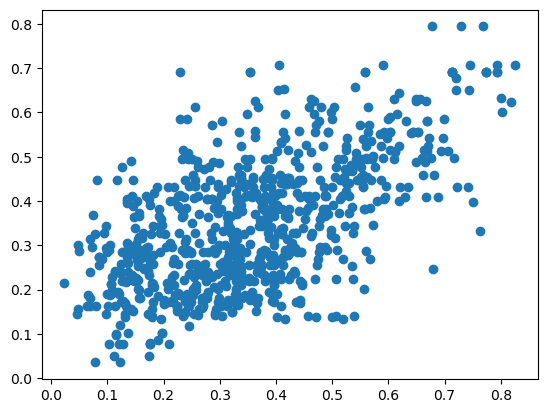

In [36]:
plt.scatter(train_y/100, [np.mean([pred_y[i][j] for i in range(1000)]) for j in range(800)])

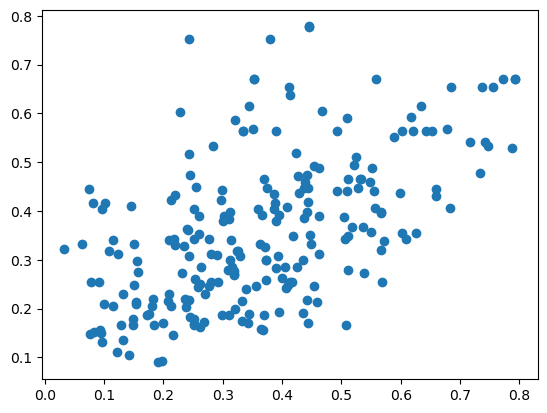

In [37]:
plt.scatter(test_y/100, [np.mean([pred_y_test[i][j] for i in range(1000)]) for j in range(230)])

In [38]:
concrete_means = [np.mean([pred_y_test[i][j]*100 for i in range(1000)]) for j in range(230)]
concrete_std = [np.std([pred_y_test[i][j]*100 for i in range(1000)], ddof = 1) for j in range(230)]

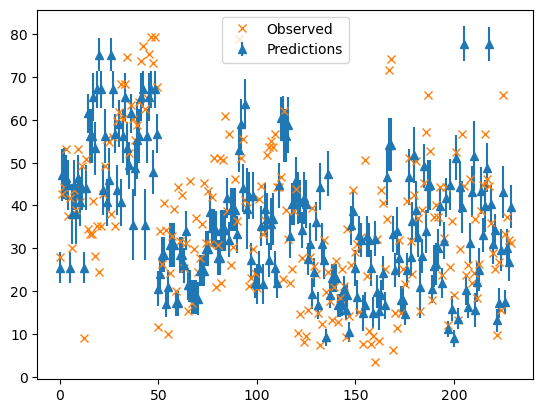

In [41]:
plt.errorbar([i for i in range(230)], concrete_means, concrete_std, linestyle='None', marker='^', label = "Predictions")
plt.plot([i for i in range(230)], test_y, linestyle='None', marker='x', label = "Observed")
plt.legend()